https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [ ]:
# References and installs
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0


import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd

from official.nlp import optimization

tf.get_logger().setLevel('ERROR')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depend

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're us

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TFG - Irony Detection - Èric Casanovas Pérez/Code/Tests Bert
df_test = pd.DataFrame()


Mounted at /content/drive
/content/drive/MyDrive/TFG - Irony Detection - Èric Casanovas Pérez/Code/Tests Bert


In [ ]:
#Fa les particions necesaries per a train, test and validation
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'datasetFINAL/train_ds',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'datasetFINAL/validation_ds',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'datasetFINAL/test_ds',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

NameError: ignored

In [ ]:
# Per carregar el BERT QUE NECESSITEM
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_multi_cased_preprocess':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)

  # Carga el modelo BERT completo (incluyendo las últimas dos capas)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')

  outputs = encoder(dict(input_word_ids=encoder_inputs['input_word_ids'],
                         input_mask=encoder_inputs['input_mask'],
                         input_type_ids=encoder_inputs['input_type_ids']), training=True)

  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:

classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

ValueError: ignored

In [ ]:

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [ ]:

epochs = 200
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-3
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[early_stop])

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/200
48/48 [==============================] - 227s 5s/step - loss: 0.6703 - binary_accuracy: 0.4382 - val_loss: 0.6015 - val_binary_accuracy: 0.7368
Epoch 2/200
48/48 [==============================] - 19s 400ms/step - loss: 0.6423 - binary_accuracy: 0.5560 - val_loss: 0.6570 - val_binary_accuracy: 0.5263
Epoch 3/200
48/48 [==============================] - 19s 406ms/step - loss: 0.6367 - binary_accuracy: 0.5736 - val_loss: 0.6254 - val_binary_accuracy: 0.4737
Epoch 4/200
48/48 [==============================] - 20s 413ms/step - loss: 0.6293 - binary_accuracy: 0.6126 - val_loss: 0.5913 - val_binary_accuracy: 0.6842
Epoch 5/200
48/48 [==============================] - 20s 417ms/step - loss: 0.6228 - binary_accuracy: 0.6243 - val_loss: 0.6197 - val_binary_accuracy: 0.5789
Epoch 6/200
48/48 [==============================] - 20s 413ms/step - loss: 0.6214 - binary_accuracy: 0.6185 - val_loss: 0.5964 

In [ ]:

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

12/12 [==============================] - 90s 2s/step - loss: 0.5756 - binary_accuracy: 0.6927
Loss: 0.5756059288978577
Accuracy: 0.6927083134651184


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


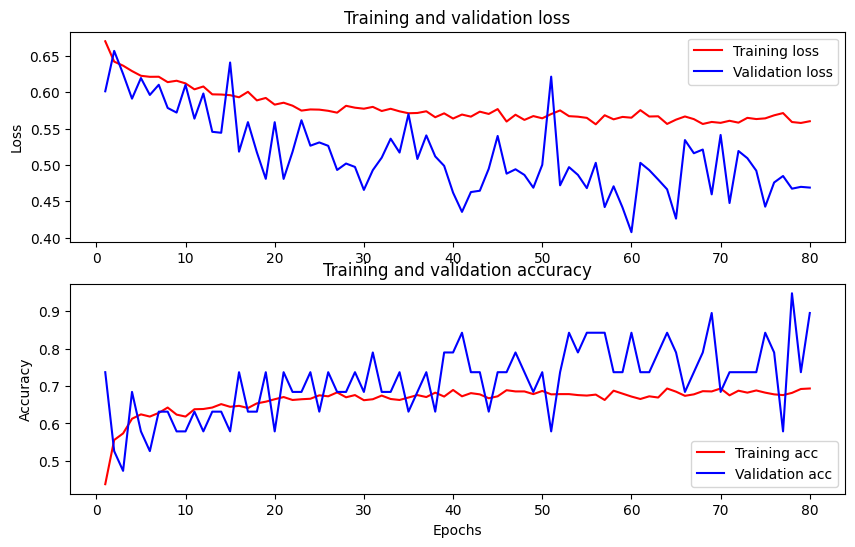

In [ ]:
# 18
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'imdb'
saved_model_path = './BaseModelV2?'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
model_json = classifier_model.to_json()

import json

with open("./Nofrozelayersv3?/my_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TFG - Irony Detection - Èric Casanovas Pérez/Code/Tests Bert

def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  # print(*result_for_printing, sep='\n')
  # print()
  return result_for_printing

dataset_name = 'imdb'
saved_model_path = './DAModelV6(DATrad1)'.format(dataset_name.replace('/', '_'))

reloaded_model = tf.saved_model.load(saved_model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/TFG - Irony Detection - Èric Casanovas Pérez/Code/Tests Bert


In [ ]:
# open file in current directory
import os
notironic = []
ironic = []
for filename in os.listdir("reviews_test_dist/ironic"):
   with open(os.path.join("reviews_test_dist/ironic", filename), 'r') as f: # open in readonly mode
         ironic.append(f.read())

for filename in os.listdir("reviews_test_dist/notironic"):
   with open(os.path.join("reviews_test_dist/notironic", filename), 'r') as f: # open in readonly mode
         notironic.append(f.read())

print(notironic)

print(ironic)

['Sneakers opta por no apabullar con ramificaciones sociales: no estaba Robert Redford entonces como para liarse la manta a la cabeza después de los fiascos de Havana o de Una proposición indecente, y aquí se pone en manos de un director capacitado, que le pone en bandeja de oro un espectáculo cinematográfico efectista, novedoso, en donde hay secundarios de auténtico lujo ( Dan Aykroyd, River Phoenix antes de caerse al suelo sobrevitaminado de adrenalina, Sidney Poitier, Ben Kingsley o James Earl Jones.', 'Tras las sangrientas escabechinas en Vietnam y Afganistán, Rambo se vuelve a quitar de enmedio y se dedica a cazar serpientes en Tailandia.', 'Bob Dylan lo dijo.', 'En un ejercicio de honestidad y coherencia, Stallone dirige con nervio y sencillez la última matanza de Rambo sin medias tintas: cuerpos que explotan, cabezas cercenadas, cráneos atravesados por flechas, violaciones, incineraciones, boquetes del tamaño de un puño.', 'Como la película es made in Hollywood, más que arañar c

In [ ]:

serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(notironic))

serving_results_notironic = tf.sigmoid(serving_results['classifier'])

serving_results_iro = reloaded_model \
            .signatures['serving_default'](tf.constant(ironic))

serving_results_ironic = tf.sigmoid(serving_results_iro['classifier'])

print(serving_results_notironic)
print(serving_results_ironic)

tf.Tensor(
[[0.87535167]
 [0.17990087]
 [0.78060275]
 [0.82809156]
 [0.95379025]
 [0.90425646]
 [0.17371218]
 [0.9282394 ]
 [0.88340974]
 [0.12922737]
 [0.31149796]
 [0.03838385]
 [0.29580954]
 [0.67197424]
 [0.26239702]
 [0.20304576]
 [0.3543685 ]
 [0.83357114]
 [0.10532773]
 [0.95114183]
 [0.19979307]
 [0.45041814]
 [0.2978837 ]
 [0.6781876 ]
 [0.5393655 ]
 [0.7809755 ]
 [0.90305704]
 [0.07308943]
 [0.2975498 ]
 [0.71212745]
 [0.47955614]
 [0.35809067]
 [0.45806348]
 [0.9428966 ]
 [0.16900465]
 [0.85476065]
 [0.13748808]
 [0.21060623]
 [0.6742329 ]
 [0.21795791]
 [0.20638059]
 [0.11355668]
 [0.5528428 ]
 [0.09637652]
 [0.7061429 ]
 [0.44399196]
 [0.08917384]
 [0.30830622]
 [0.90116173]
 [0.33554336]
 [0.57053316]
 [0.9507784 ]
 [0.40348667]
 [0.88093966]
 [0.22122113]
 [0.30273035]
 [0.50997156]
 [0.44625828]
 [0.30497578]
 [0.90811795]
 [0.23758323]
 [0.53503865]
 [0.5814956 ]
 [0.9535852 ]
 [0.7928967 ]
 [0.23749505]
 [0.88841605]
 [0.94478065]
 [0.4150605 ]
 [0.71388596]
 [0.54183

In [ ]:
# for i in range(len(serving_results_notironic)):
#   print(serving_results_notironic[i][0])

results1 = print_my_examples(notironic, serving_results_notironic)
print("\n/////////////////////////\n")

scores1 = []
for result in results1:
  score = ""
  for i in range(8):
    score = score + result[len(result) +i-8 ]
    #print(score)
  scores1.append(float(score))

print("\n/////////////////////////\n")
# print(scores1)

true_negative = 0
false_positive = 0
for score in scores1:
  if score >= 0.5:
    true_negative = true_negative + 1
  else:
    false_positive = false_positive + 1

print(true_negative)
print(false_positive)


/////////////////////////


/////////////////////////

102
88


In [ ]:

results0 = print_my_examples(ironic, serving_results_ironic)
print("\n/////////////////////////\n")

scores0 = []
for result in results0:
  score = ""
  for i in range(8):
    score = score + result[len(result) +i-8 ]
    #print(score)
  scores0.append(float(score))

print("\n/////////////////////////\n")
print(scores0)

true_positive = 0
false_negative = 0
for score in scores0:
  if score < 0.5:
    true_positive = true_positive + 1
  else:
    false_negative = false_negative + 1

print(true_positive)
print(false_negative)


/////////////////////////


/////////////////////////

[0.387681, 0.828438, 0.467635, 0.904091, 0.601633, 0.350573, 0.206192, 0.146203, 0.907098, 0.909808, 0.966407, 0.47816, 0.753593, 0.931382, 0.081404, 0.80973, 0.713617, 0.079801, 0.315799, 0.245154, 0.36216, 0.959049, 0.466741, 0.14715, 0.707489, 0.140528, 0.730918, 0.941931, 0.774465, 0.080871, 0.311927, 0.434145, 0.439869, 0.047134, 0.252526, 0.250727, 0.818191, 0.726834, 0.925218, 0.892622, 0.126135, 0.772258, 0.633092, 0.454887, 0.941521, 0.739425, 0.19847, 0.093045, 0.870512, 0.737731, 0.812303, 0.6707, 0.527706, 0.293822, 0.285165, 0.684138, 0.056221, 0.653855, 0.63885, 0.663497, 0.247306, 0.114009, 0.217305]
31
32


In [ ]:
accuracy = (true_negative + true_positive) / (true_negative + true_positive + false_negative + false_positive )
precision = true_positive / (true_positive + false_positive)

recall = true_negative / (true_negative + false_negative)
f1_score = (2*(precision*recall))/(recall+precision)

print("ACCURACCY: ")
print(accuracy)
print("PRECISION: ")
print(precision)
print("RECALL: ")
print(recall)
print("F1-SCORE: ")
print(f1_score)

ACCURACCY: 
0.525691699604743
PRECISION: 
0.2605042016806723
RECALL: 
0.7611940298507462
F1-SCORE: 
0.3881659710287258
